# PyTorch101 - Part 2 - Autograd
This time we will use the automatic differentiation tool integrated inside PyTorch, autograd.
We already know why taking gradients is essential in Deep Learning (for now), so this feature is a must.

In [2]:
import torch
print(torch.__version__)

0.4.0


## Preliminaries

- A *torch.Tensor* with the attribute *requires_grad=True* will track all the operations it performs. This flag is *True* by default and can also be set later using the in-place operator *requires\_grad\_(True)*
- When the forward pass is finished, we can call *.backward()* and compute the gradients which are stored in the *.grad* attribute
- The *.detach()* operation will stop the operation tracking
- Using *with torch.no\_grad():* will avoid the tracking of gradients inside the block
- *torch.Tensor* and *torch.Function* build an acyclic graph which is used to compute the complete gradient. The function which generated the tensor is found inside the *.grad\_fn* attribute (*None* if user-generated)

### Comparison with TF
In contrast with the usage of TF, PyTorch seems to have a lot of control on the backward pass: instead of handling it implicitly when using the optimizer *minimize()* function, here we can directly access the gradients.

Now we can have some fun and try things out!

## Autograd basics

In [35]:
# Tensor definition with tracked gradient
x = torch.ones(2, 2, requires_grad=True)
# Simple op
y = x + 7
# More complex ops
z = y * y * 3
# Also compute z's gradient
z.retain_grad()
out = z.mean()
# Get the grad_fn of y
print(y.grad_fn)
# Compute backward grads
out.backward()
# Print some grads
print(x.grad)
print(z.grad)

tensor([[ 12.,  12.],
        [ 12.,  12.]])
tensor([[ 0.2500,  0.2500],
        [ 0.2500,  0.2500]])


Remember that all these tensors have an already computed value, i.e. the forward pass is already done by declaring it. This is a great difference, probably **the** great difference between TF (classic, not eager) and PyTorch.

### Note
I experimented a little bit with the backward op encountering different errors:
- If you call *.backward()* a second time it will raise an error (avoid by using *retain\_graph=True* if needed)
- Autograd works only for scalar values 🤬 (see later the follow-up)

## Dynamically creating tensors and autograd
We can create arbitrary long chains of tensor ops, and autograd will behave just as before.

In [27]:
x = torch.randn(3, requires_grad=True)
y = x * 2
while y.data.norm() < 1000: # L2-norm, just use the *p* parameter inside the *norm()* function for other exponents
    y = y * 2
print(y)

tensor([-1968.6005,   -96.0793,   308.6039])


With this snippet of code, we are first generating a tensor of normal random values, then we are taking the 2nd-power till the L2-norm of the vector exceed 1000. 

Next we want to compute the gradient of *y*. As I was saying before, gradients of tensors do not work out-of-the-box, while we can make them work by providing a "scaling" for them, with the correct shape obviously.

In [28]:
# Taking the gradient
grad_scale = torch.tensor([1, 1, 1], dtype=torch.float)
y.backward(grad_scale)
print(x.grad)

tensor([ 1024.,  1024.,  1024.])


This way we can verify that we multiplied 10 times.

Given this new "scaling" trick, I want to go back and inspect the other gradients, and compare them with the manually computed ones (by me).

In [31]:
# Tensor definition with tracked gradient
x = torch.ones(2, 2, requires_grad=True)
grad_scale = torch.ones_like(x, dtype=torch.float)
# Simple op
y = x + 7
# More complex ops
z = y * y * 3
out = z.mean()
# Gradients
z.backward(grad_scale)
print(x.grad)

tensor([[ 48.,  48.],
        [ 48.,  48.]])
None


## Testing Autograd
The official tutorial stops here, but for the sake of understanding I will continue with a quite simple experiment, good ol Linear Regression. 

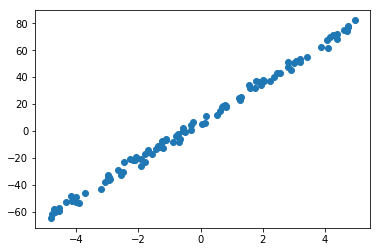

In [231]:
import numpy as np
import matplotlib.pyplot as plt

LENGTH = 100

# Create a stupid dataset
X = np.random.rand(LENGTH).astype(np.float) * 10 - 5
noise = np.random.randn(LENGTH) * 2.5
Y = 14.4 * X + 7.5 + noise
# Plot these things
plt.scatter(X, Y)
plt.show()

Next we want to create a model (one weight and one bias term), an error (MSE) and optimize the "model" using the gradients (through a learning rate)

[Epoch 1 ] MSE: 166917.27318744475
[Epoch 2 ] MSE: 56681.945577653845
[Epoch 3 ] MSE: 20052.39726437068
[Epoch 4 ] MSE: 7679.706503279205
[Epoch 5 ] MSE: 3373.8922300899826
[Epoch 6 ] MSE: 1797.1046062855546
[Epoch 7 ] MSE: 1172.6464766351735
[Epoch 8 ] MSE: 898.4938922669737
[Epoch 9 ] MSE: 763.9654393345714
[Epoch 10 ] MSE: 691.2061794532269
[Epoch 10 ] MSE: 6068.167368953221
W: tensor([  6.5934,  14.3346], dtype=torch.float64)
691.2061794532269


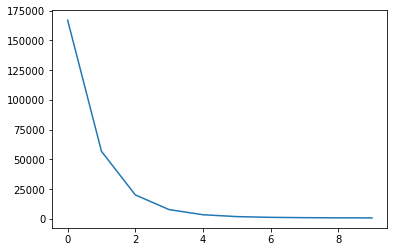

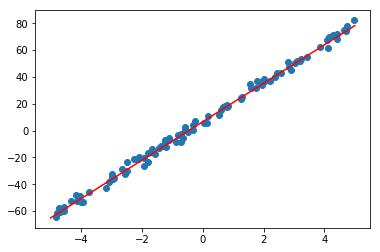

In [237]:
# Setting seed for reproducibility (also need torch.cuda.manual_seed_all() in case of GPU usage)
torch.manual_seed(42)

# Model definition
W = torch.tensor([0, 0], dtype=torch.double, requires_grad=True)#torch.randn(2, dtype=torch.double, requires_grad=True)
_X = torch.from_numpy(X)
_Y = torch.from_numpy(Y)

LR = 0.001

mses = []

for i in range(10):
    # Computing predictions
    Y_pred = W[1] * _X + W[0]
    # Error definition
    mse = ((_Y - Y_pred)**2).sum()
    mses.append(mse.item())
    if i % 1 == 0:
        print("[Epoch", i+1, "\b] MSE:", mse.item())
    # Taking gradient and updating
    mse.backward()
    W.data = W.data - LR * W.grad
    W.grad.data.zero_()

Y_pred = W[1] * _X + W[0] * 0
mse = ((_Y - Y_pred)**2).sum()
print("[Epoch", i+1, "\b] MSE:", mse.item())
print("W:", W)
print(min(mses))

plt.plot(mses)
plt.show()

plt.scatter(X,Y)
plt.plot([-5, 5], [W[1]*-5+W[0], W[1]*5+W[0]], color="red")
plt.show()

After many trials, I understood that I needed to manually clear the gradients after each iteration because
> Every time a variable is back propogated through, the gradient will be accumulated instead of being replaced. (This makes it easier for rnn, because each module will be back propogated through several times.)

To clear the gradients use *.grad.data.zero_()*.

Anyway, we can see how the linear regression works nicely using the computed gradient (which are trivial in this case, but still they works).